In [70]:
%pylab inline

import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score

import datetime, time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [71]:
# Read data
wnv_train = pd.read_csv('../working/train_f.csv', index_col=0)
wnv_test = pd.read_csv('../working/test_f.csv', index_col=0)
#f_names = wnv_train.columns[2:]

In [72]:
# convert list of labels to binary class matrix
labels = wnv_train.WnvPresent.values.astype('int')
yr_train = labels
wnv_train.drop('NumMosquitos', axis=1, inplace=True)
wnv_train.drop('WnvPresent', axis=1, inplace=True)
f_names = wnv_train.columns

In [73]:
# raw data
#yr_train = wnv_train[:,1].astype(int)
Xr_train =(wnv_train.values).astype('float64')
Xr_test = (wnv_test.values).astype('float64')

# normalize data
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

X_train, X_test, y_train, y_test = train_test_split(Xn_train, yr_train)

In [74]:
#clf = KNeighborsClassifier(n_neighbors=30)
clf = ExtraTreesClassifier(n_estimators=5000, n_jobs=3)
#clf.fit(X_train, y_train)
clf.fit(Xn_train, yr_train)

# use the model to predict the labels of the test data
#predicted = clf.predict(X_test)
proba = clf.predict_proba(X_test)
expected = y_test

In [75]:
# accuracy
matches = (predicted == expected)
print matches.sum() / float(len(matches))

# f1 score

print classification_report(expected, predicted)

# confusion matrix
print confusion_matrix(expected, predicted)

# auc
print roc_auc_score(expected, proba[:,1])

0.905595736582
             precision    recall  f1-score   support

          0       0.94      0.96      0.95      2474
          1       0.02      0.01      0.02       153

avg / total       0.89      0.91      0.90      2627

[[2377   97]
 [ 151    2]]
0.993919772166


Area under the ROC curve : 0.993920


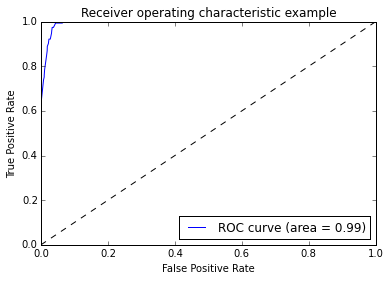

In [76]:
#print np.count_nonzero(predicted == 1)
#print np.count_nonzero(y_test)
#np.max(proba[:,1])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(expected, proba[:,1])
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc

# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [77]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(f_names)):
#for f in range(15):
    print("%d. %s (%f)" % (f + 1, f_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. Longitude (0.429226)
2. Latitude (0.401941)
3. CULEX PIPIENS (0.016416)
4. CULEX PIPIENS/RESTUANS (0.015945)
5. CULEX RESTUANS (0.011700)
6. Week (0.003215)
7. Year (0.002725)
8. CULEX TERRITANS (0.002080)
9. StnPressure_2_a21 (0.001930)
10. DewPoint_1_a21 (0.001887)
11. DewPoint_1_a14 (0.001720)
12. ResultSpeed_1_a21 (0.001598)
13. WetBulb_1_a21 (0.001553)
14. WetBulb_1_a14 (0.001359)
15. StnPressure_2_d4 (0.001324)
16. DewPoint_2_a21 (0.001254)
17. StnPressure_1_d4 (0.001213)
18. ResultSpeed_2_a21 (0.001167)
19. Tmin_1_a21 (0.001142)
20. SeaLevel_2_d4 (0.001105)
21. StnPressure_1_a21 (0.001102)
22. Tmin_2_a21 (0.001097)
23. WetBulb_2_a21 (0.001095)
24. PrecipTotal_2_a7 (0.001088)
25. Tavg_2_a21 (0.001081)
26. Cool_2_a21 (0.001072)
27. Cool_1_a21 (0.001066)
28. DewPoint_2_a14 (0.001033)
29. StnPressure_2_a14 (0.000985)
30. PrecipTotal_2_a14 (0.000973)
31. AvgSpeed_1_a21 (0.000970)
32. Tavg_1_a21 (0.000955)
33. DewPoint_1_d1 (0.000950)
34. ResultSpeed_1_a14 (0.00093

In [78]:
proba = clf.predict_proba(Xn_test)
print np.max(proba[:,1])

0.36886410253


In [79]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba[:,1], "../working/sklearn_test_" + st + ".csv")